In [1]:
''' 1. 모듈 임포트 '''
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.5.0+cu101  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. FashionMNIST 데이터 다운로드 '''
trainset = datasets.FashionMNIST(
    root      = '../data/FashionMNIST', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True)

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break 

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


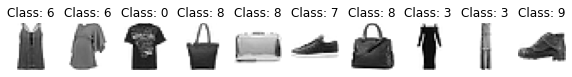

In [6]:
''' 4. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),)

        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

model = AE().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = 0.005)
criterion = nn.MSELoss()

print("Model: ", model)
print("Device: ", DEVICE)

Model:  AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
)
Device:  cuda


In [9]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)

        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [10]:
def get_lv(model, train_loader):
    lv_lst = []
    model.eval()
    with torch.no_grad():
        for image, _ in train_loader:
            image = image.view(-1, 28 * 28).to(DEVICE)
            encoded, _ = model(image)
            lv_lst.append(encoded.to("cpu").numpy())
    lv = np.reshape(np.array(lv_lst), (-1, 16))
    return lv

In [11]:
''' Training'''
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    print("\n")

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 0.169212
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 0.047041
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.047991
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.028955
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.030819
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.028332
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.026910
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.029047
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.026126
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.028116


Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.024705
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.025493
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.024471
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.025416
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.024310
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.023185
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.024337
Train Epoch: 2 [44800/60000 (75%)]	Train Loss: 0.021463
Tr

In [12]:
lv = get_lv(model, train_loader)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators = 20,
                                  max_depth = 10,
                                  random_state = 42)
rf_model_trained = rf_model.fit(trainset.train_data.view(-1, 28 * 28).numpy(), trainset.train_labels.numpy())
rf_model_predicted_train = rf_model.predict(trainset.train_data.view(-1, 28 * 28).numpy())
print("Trainset Accuracy: %.2f" % (accuracy_score(list(trainset.train_labels.numpy()), rf_model_predicted_train) * 100), "%") 

/home/justin/101/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/justin/101/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/justin/101/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Trainset Accuracy: 87.92 %


/home/justin/101/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [14]:
rf_model = RandomForestClassifier(n_estimators = 20,
                                  max_depth = 10,
                                  random_state = 42)
rf_model_trained = rf_model.fit(lv, trainset.train_labels.numpy())
rf_model_predicted_train = rf_model.predict(lv)
print("Trainset Accuracy: %.2f" % (accuracy_score(list(trainset.train_labels.numpy()), rf_model_predicted_train) * 100), "%") 

Trainset Accuracy: 22.48 %


/home/justin/101/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [16]:
lv.shape

(60000, 16)

In [19]:
trainset.train_data.numpy().shape

/home/justin/101/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


(60000, 28, 28)